## Install Packages

In [ ]:
!pip install -r requirements.txt -q

## Read Data

前処理の為に、train/dev/testを結合し、必要なカラムのみ抽出する。

In [ ]:
import re
import gc
import warnings
import unicodedata
import numpy as np
import pandas as pd

warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 10000)

In [ ]:
train = pd.read_json('data/train.jsonl', lines=True)
dev = pd.read_json('data/dev.jsonl', lines=True)
test = pd.read_json('data/test.jsonl', lines=True)
data = pd.concat([train,dev,test]).reset_index(drop=True)
data = data[['src','tgt']]


del train, dev, test
gc.collect()

0

In [ ]:
data.head(3)

,src,tgt
0,USBメモリは、パソコンに付いている四角形のポートに収まります。エラーが発生したり、USBメモリの内容が表示されない場合は、パソコンの修復機能を使用して、ドライバーやソフトウェアを更新する必要があるかもしれません。を押してファイルエクスプローラーを開く windowsのファイルエクスプローラーが開きます。ここからUSBメモリの操作ができます。右側にメニューが表示されます。最初に「PC」の隣の「>」をクリックして、USBメモリのアイコンを表示する必要があるかもしれません。ドライブを右クリックして表示されるメニューの一番下にあります。チェック は、「ツール」タブの上部にある「エラーチェック」セクションにあります。修復処理中は、画面に表示される指示に従う必要があるかもしれません。例えば、「スキャンと修復」をクリックして、USBメモリの修復の実行を確認する必要があるでしょう。USBドライブの問題がドライバーまたはソフトウェアによるものであれば、正常に作動するはずです。,USBメモリをパソコンに差し込む。Win+E。USBメモリのアイコンを右クリックする。プロパティ をクリックする。チェック をクリックする。WindowsがUSBメモリを修復するのを待つ。修復が完了したら閉じる をクリックする。
1,USBメモリは、パソコンに付いている四角形のポートに収まります。エラーが発生したり、USBメモリの内容が表示されない場合は、パソコンの修復機能を使用して、ドライバーやソフトウェアを更新する必要があるかもしれません。ファインダーは、Dockに表示されている青い顔のようなアイコンです。「移動」ドロップダウンメニューの下部付近にあります。ディスクユーティリティ は、ハードドライブの上に聴診器が付いたアイコンです。ポップアップウィンドウ上に表示される青いボタンが 実行 です。ディスクユーティリティが、ソフトウェアやドライバーに関連する問題を修復します。USBドライブの問題がドライバーやソフトウェアによるものであれば、正常に作動するはずです。MacでUSBドライブを使い終わった後は、引き抜く前に必ず「取り出す」操作をします。この操作によって、USBドライブの損傷を防ぎます。取り出すには、ファインダーのUSBドライブ右側の「取り出しボタン」か、デスクトップでUSBドライブをDockにある「取り出しアイコン」にドラッグ&ドロップします。,USBメモリをパソコンに差し込む。ファインダーを開く。ユーティリティ をクリックする。ディスクユーティリティ をダブルクリックする。実行 をクリックする。スキャンが完了するのを待つ。完了 をクリックする。をクリックする。
2,パソコンのUSBポートにUSBドライブを差し込みます。を押してファイルエクスプローラーを開く windowsのファイルエクスプローラーが開きます。ここからUSBメモリの操作ができます。右側にメニューが表示されます。最初に「PC」の隣の「>」をクリックして、USBメモリのアイコンを表示する必要があるかもしれません。USBドライブを右クリックすると表れるメニューの中にあります。クリックするとフォーマット画面が開きます。「ファイルシステム」下のドロップダウンメニューから、USBドライブをフォーマットするファイルシステムを選択します。オプションは以下の通りです。NTFS - Windows OSのデフォルトフォーマットです。このフォーマットは、Windowsでのみ使用できます。FAT32 - 最も広く互換性のあるフォーマットです。WindowsとMacで使用できますが、32ギガバイトまでという容量の制限があります。exFAT（既定） - WindowsとMacで使用でき、容量の制限がありません。以前USBドライブをフォーマットしたことがあり、USBドライブが壊れていないことが確実であれば、「クイック フォーマット」のボックスにチェックを入れることもできます。WindowsがUSBドライブのフォーマットを開始します。これで、USBドライブのフォーマットは完了です。,USBドライブをパソコンに接続する。Win+E。USBメモリのアイコンを右クリックする。フォーマットをクリックする。ファイルシステムを選択する。開始 をクリックした後、OK をクリックする。OK をクリックする。


In [ ]:
data['unbalance'] = [True if len(source) <= len(target) else False for source, target in zip(data['src'], data['tgt'])]
count_unbalance = len(data.query('unbalance == True'))

In [ ]:
print(f'Data総数: {len(data)}\n')
print(f'カラム別の欠損値数:\n{data.isnull().sum()}\n')
print(f'データ重複(レコード単位): {data.duplicated().sum()}\n')
print(f'sourceテキストより長いtargetテキストがある件数: {count_unbalance}')

Data総数: 5068

カラム別の欠損値数:
src          0
tgt          0
unbalance    0
dtype: int64

データ重複(レコード単位): 3

sourceテキストより長いtargetテキストがある件数: 26


## Preprocess

ノイズ除去と、targetテキストの後半に含まれている不要な繰り返しの文章を取り除く。

In [ ]:
def text_normalize(text):
    text = text.strip()
    text = unicodedata.normalize('NFKC', text)
    return text

def text_preprocess(text):
    text = text.replace('\n', '').replace('\t','')
    text = text.replace('　', '').replace(' ', '')
    text = re.sub(r'(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+$,%#]+)', '' , text)
    return text

def remove_repetition(text):
    split_text = text.split('。')[:-1]
    try:
        if split_text[-1] in split_text[-2]:
            split_text = split_text[:-1]
    except IndexError:
        pass
    split_text = [sentence+'。' for sentence in split_text]
    new_text = ''.join(split_text)
    return new_text

def apply_preprocess(df):
    df = df[['src','tgt']]
    df = df.drop_duplicates()
    df['src'] = df['src'].map(text_normalize)
    df['tgt'] = df['tgt'].map(text_normalize)
    df['src'] = df['src'].map(text_preprocess)
    df['tgt'] = df['tgt'].map(text_preprocess)
    df['tgt'] = df['tgt'].map(remove_repetition)
    return df

data = apply_preprocess(data)

In [ ]:
data.head(3)

,src,tgt
0,USBメモリは、パソコンに付いている四角形のポートに収まります。エラーが発生したり、USBメモリの内容が表示されない場合は、パソコンの修復機能を使用して、ドライバーやソフトウェアを更新する必要があるかもしれません。を押してファイルエクスプローラーを開くwindowsのファイルエクスプローラーが開きます。ここからUSBメモリの操作ができます。右側にメニューが表示されます。最初に「PC」の隣の「>」をクリックして、USBメモリのアイコンを表示する必要があるかもしれません。ドライブを右クリックして表示されるメニューの一番下にあります。チェックは、「ツール」タブの上部にある「エラーチェック」セクションにあります。修復処理中は、画面に表示される指示に従う必要があるかもしれません。例えば、「スキャンと修復」をクリックして、USBメモリの修復の実行を確認する必要があるでしょう。USBドライブの問題がドライバーまたはソフトウェアによるものであれば、正常に作動するはずです。,USBメモリをパソコンに差し込む。Win+E。USBメモリのアイコンを右クリックする。プロパティをクリックする。チェックをクリックする。WindowsがUSBメモリを修復するのを待つ。修復が完了したら閉じるをクリックする。
1,USBメモリは、パソコンに付いている四角形のポートに収まります。エラーが発生したり、USBメモリの内容が表示されない場合は、パソコンの修復機能を使用して、ドライバーやソフトウェアを更新する必要があるかもしれません。ファインダーは、Dockに表示されている青い顔のようなアイコンです。「移動」ドロップダウンメニューの下部付近にあります。ディスクユーティリティは、ハードドライブの上に聴診器が付いたアイコンです。ポップアップウィンドウ上に表示される青いボタンが実行です。ディスクユーティリティが、ソフトウェアやドライバーに関連する問題を修復します。USBドライブの問題がドライバーやソフトウェアによるものであれば、正常に作動するはずです。MacでUSBドライブを使い終わった後は、引き抜く前に必ず「取り出す」操作をします。この操作によって、USBドライブの損傷を防ぎます。取り出すには、ファインダーのUSBドライブ右側の「取り出しボタン」か、デスクトップでUSBドライブをDockにある「取り出しアイコン」にドラッグ&ドロップします。,USBメモリをパソコンに差し込む。ファインダーを開く。ユーティリティをクリックする。ディスクユーティリティをダブルクリックする。実行をクリックする。スキャンが完了するのを待つ。完了をクリックする。
2,パソコンのUSBポートにUSBドライブを差し込みます。を押してファイルエクスプローラーを開くwindowsのファイルエクスプローラーが開きます。ここからUSBメモリの操作ができます。右側にメニューが表示されます。最初に「PC」の隣の「>」をクリックして、USBメモリのアイコンを表示する必要があるかもしれません。USBドライブを右クリックすると表れるメニューの中にあります。クリックするとフォーマット画面が開きます。「ファイルシステム」下のドロップダウンメニューから、USBドライブをフォーマットするファイルシステムを選択します。オプションは以下の通りです。NTFS-WindowsOSのデフォルトフォーマットです。このフォーマットは、Windowsでのみ使用できます。FAT32-最も広く互換性のあるフォーマットです。WindowsとMacで使用できますが、32ギガバイトまでという容量の制限があります。exFAT(既定)-WindowsとMacで使用でき、容量の制限がありません。以前USBドライブをフォーマットしたことがあり、USBドライブが壊れていないことが確実であれば、「クイックフォーマット」のボックスにチェックを入れることもできます。WindowsがUSBドライブのフォーマットを開始します。これで、USBドライブのフォーマットは完了です。,USBドライブをパソコンに接続する。Win+E。USBメモリのアイコンを右クリックする。フォーマットをクリックする。ファイルシステムを選択する。開始をクリックした後、OKをクリックする。


## Quick EDA

In [ ]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

tokenizer_for_eda = AutoTokenizer.from_pretrained(
    'sonoisa/t5-base-japanese-mC4-Wikipedia', 
    is_fast=True
    )

def text_length_plot(df, column, fontsize=15):
    text_len = [len(body) for body in df[column]]
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn')
    plt.scatter(range(0, len(text_len)), text_len, marker='.')
    plt.tick_params(labelsize=fontsize)
    plt.xlabel('Data Length', fontsize=fontsize)
    plt.ylabel('Text Length', fontsize=fontsize)
    plt.title(f'Text Length "{column}" column', fontsize=fontsize)
    plt.show()    


def sequence_length_plot(df, column, tokenizer, fontsize=15):
    encoded = tokenizer(df[column].tolist())
    sequence_len = [len(ids) for ids in encoded['input_ids']]
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn')
    plt.scatter(range(0, len(sequence_len)), sequence_len, marker='.', color='orange')
    plt.tick_params(labelsize=fontsize)
    plt.xlabel('Data Length', fontsize=fontsize)
    plt.ylabel('Sequence Length', fontsize=fontsize)
    plt.title(f'Sequence Length "{column}" column', fontsize=fontsize)
    plt.show()

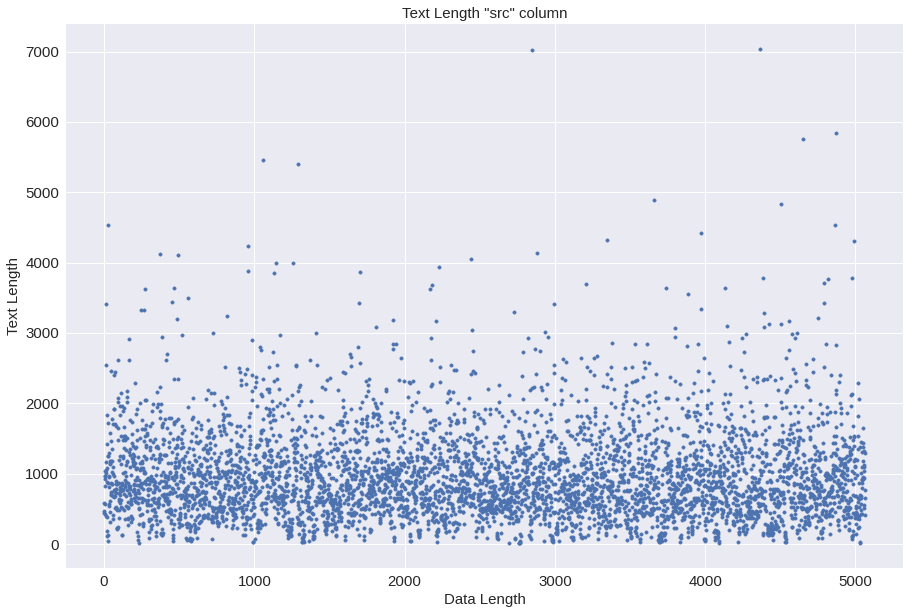

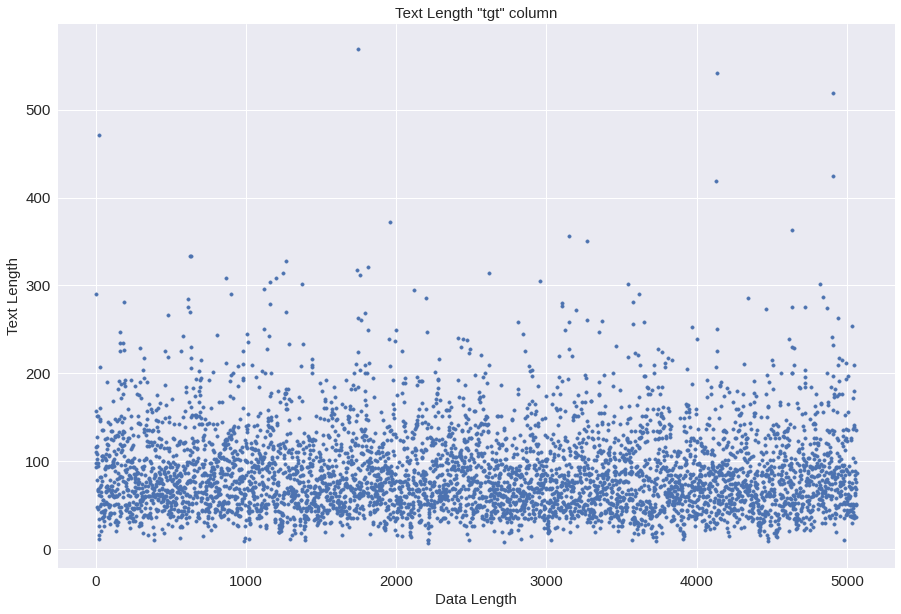

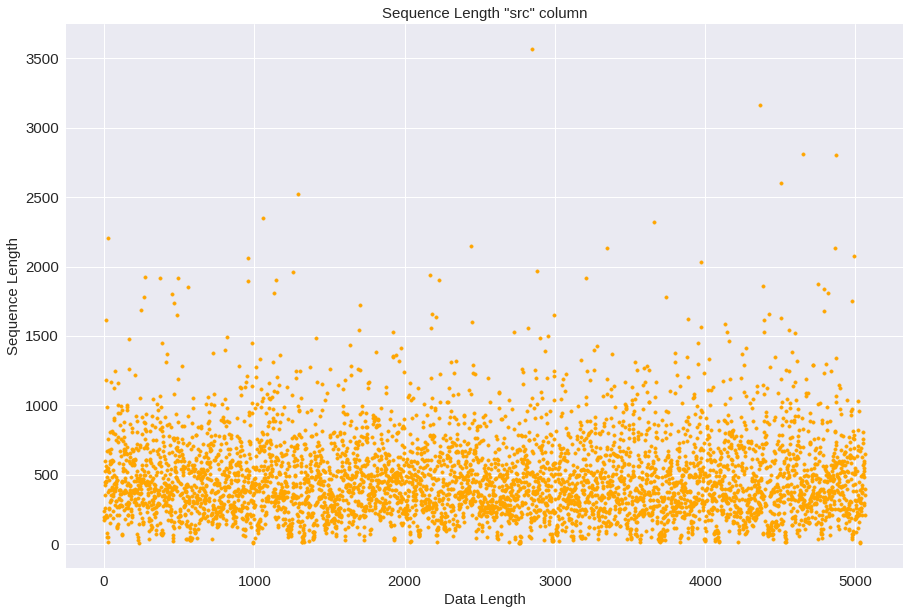

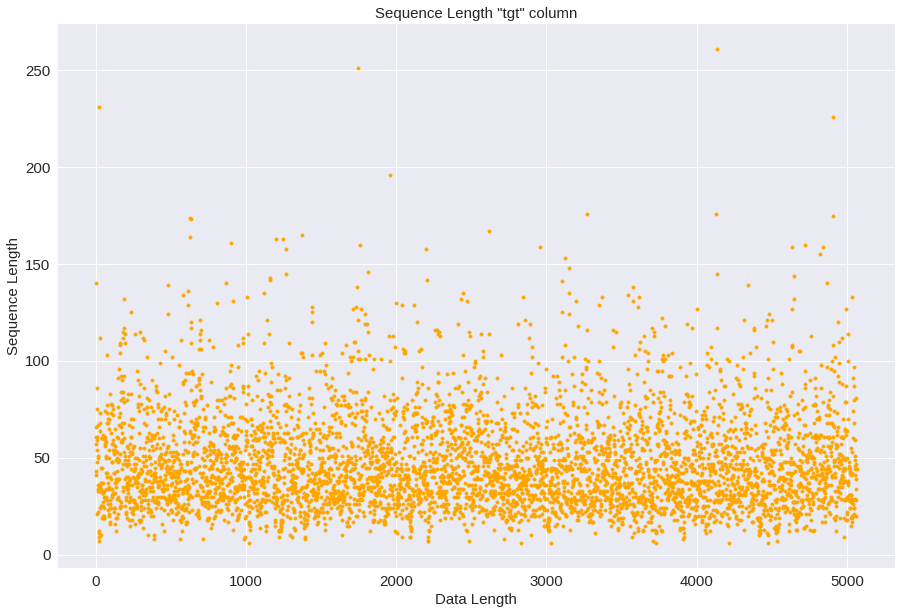

In [ ]:
text_length_plot(data, 'src')
text_length_plot(data, 'tgt')
sequence_length_plot(data, 'src', tokenizer_for_eda)
sequence_length_plot(data, 'tgt', tokenizer_for_eda)

## Model Finetuning

In [ ]:
import random
import multiprocessing
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sumeval.metrics.rouge import RougeCalculator
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import Adafactor, AdafactorSchedule

In [ ]:
class Cfg:
    seed = 42
    epochs = 5
    max_seq_length = 512
    max_length = 64
    train_batch_size = 8
    val_batch_size = 64
    repetition_penalty = 1.7
    source_name = 'src'
    target_name = 'tgt'
    model_name = 'sonoisa/t5-base-japanese-mC4-Wikipedia'
    n_gpus = torch.cuda.device_count()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
seed_everything(Cfg.seed, workers=True)

Global seed set to 42


42

### Create Dataset

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=Cfg.seed)
train, val = train_test_split(train, test_size=0.2, random_state=Cfg.seed)

print(f'Train総数: {len(train)}')
print(f'Validation総数: {len(val)}')
print(f'Test総数: {len(test)}')

Train総数: 3241
Validation総数: 811
Test総数: 1013


Data Augmentation

In [ ]:
def random_char_deletion(text, random_state=42):
    '''
    無作為に1センテンスにつき、1文字を削除
    '''
    random.seed(random_state)
    new_text = []
    for sentence in text.split('。')[:-1]:
        if sentence != '':
            sentence += '。'
            chars = list(sentence)
            while True:
                del_char = random.choice(chars)
                if del_char not in ['、', '。']:
                    break
            chars.remove(del_char)
            new_sentence = ''.join(chars)
            new_text.append(new_sentence)
    new_text = ''.join(new_text)
    return new_text

def apply_randomCharDeletion(df, config):
    new_df = df.copy()
    new_df[config.source_name] = df[config.source_name].map(random_char_deletion)
    return new_df

In [ ]:
aug_data = apply_randomCharDeletion(train, Cfg)
aug_data.to_csv('aug_data.csv', index=False)
aug_data = pd.read_csv('aug_data.csv').dropna()

train = pd.concat([train, aug_data])
print(f'Train総数: {len(train)}')

Train総数: 6480


In [ ]:
class SummDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        source_text = data_row[self.config.source_name]
        target_text = data_row[self.config.target_name]

        encoded_source = self.tokenizer.batch_encode_plus(
            [source_text],  
            max_length=self.config.max_seq_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        encoded_target = self.tokenizer.batch_encode_plus(
            [target_text],  
            max_length=self.config.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'source_ids': encoded_source['input_ids'].flatten(),
            'source_mask': encoded_source['attention_mask'].flatten(),
            'target_ids': encoded_target['input_ids'].flatten(),
            'target_mask': encoded_target['attention_mask'].flatten()
        } 


class SummDataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, config):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.config = config
        self.tokenizer = T5Tokenizer.from_pretrained(self.config.model_name, is_fast=True)

    def create_dataset(self, mode):
        return (
            SummDataset(self.train_data, self.tokenizer, self.config) 
            if mode == 'train'
            else SummDataset(self.val_data, self.tokenizer, self.config)
            if mode == 'val' 
            else SummDataset(self.test_data, self.tokenizer, self.config)
            )
    
    def train_dataloader(self):
        train_ds = self.create_dataset(mode='train')
        train_loader = DataLoader(train_ds,  
                                  batch_size=self.config.train_batch_size,
                                  num_workers=multiprocessing.cpu_count(), 
                                  pin_memory=True,
                                  drop_last=True,
                                  shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_ds = self.create_dataset(mode='val')
        val_loader = DataLoader(val_ds,  
                                batch_size=self.config.val_batch_size,
                                num_workers=multiprocessing.cpu_count(), 
                                pin_memory=True,
                                drop_last=False,
                                shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_ds = self.create_dataset(mode='test')
        test_loader = DataLoader(test_ds,  
                                 batch_size=self.config.val_batch_size,
                                 num_workers=multiprocessing.cpu_count(), 
                                 pin_memory=True,
                                 drop_last=False,
                                 shuffle=False)
        return test_loader

### Create Model

Optimizer 

`Adafactor`: T5、mT5の事前学習に選択されているオプティマイザ−。


In [ ]:
class SummModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.t5_ja = T5ForConditionalGeneration.from_pretrained(self.config.model_name)
        self.tokenizer = T5Tokenizer.from_pretrained(self.config.model_name, is_fast=True)

    def _step(self, batch):
        labels = batch['target_ids']
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        output = self.t5_ja(input_ids=batch['source_ids'],
                            attention_mask=batch['source_mask'],
                            decoder_attention_mask=batch['target_mask'],
                            labels=labels)
        loss = output.loss
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        val_loss = self._step(batch)
        self.log('val_loss', val_loss)

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = Adafactor(self.parameters(), warmup_init=True)
        scheduler = AdafactorSchedule(optimizer)
        return [optimizer], [scheduler]

### FineTuning

In [ ]:
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss', 
                                          mode='min', 
                                          save_top_k=1,  
                                          save_weights_only=True, 
                                          dirpath=f'model_seed_{Cfg.seed}/')
es_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=1)
swa_callback = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=2,
                                                      annealing_epochs=3, 
                                                      annealing_strategy='linear')
tb_logger = pl.loggers.TensorBoardLogger(f'model_seed_{Cfg.seed}_logs/')

trainer = pl.Trainer(max_epochs=Cfg.epochs,
                     gpus=Cfg.n_gpus, 
                     logger=tb_logger,
                     callbacks=[checkpoint,es_callback,swa_callback])

model = SummModel(Cfg)
model.to(Cfg.device)
datamodule = SummDataModule(train, val, test, Cfg)
trainer.fit(model, datamodule=datamodule)

del model
gc.collect()
torch.cuda.empty_cache()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | t5_ja | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Swapping scheduler <transformers.optimization.AdafactorSchedule object at 0x7fb24aab9e10> for <torch.optim.swa_utils.SWALR object at 0x7fb24a3a9bd0>


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./

## Evaluate

In [ ]:
model = SummModel(Cfg)
model.to(Cfg.device)
model.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict']) 
trainer.test(model, datamodule=datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 2.4126925468444824}
--------------------------------------------------------------------------------


[{'val_loss': 2.4126925468444824}]

In [ ]:
def inference(text, tokenizer, model, config):
    encoded = tokenizer.batch_encode_plus(
        [text],  
        max_length=config.max_seq_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
        )
    model.to(config.device)
    encoded = encoded.to(config.device)
    model.eval()
    with torch.no_grad():
        output = model.generate(**encoded, repetition_penalty=config.repetition_penalty)
    decoded = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]
    return decoded

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(Cfg.model_name, is_fast=True)
preds = [inference(source, tokenizer, model.t5_ja, Cfg) for source in tqdm(test[Cfg.source_name])]

  0%|          | 0/1013 [00:00<?, ?it/s]

In [ ]:
def rouge_calc(preds, targets):
    rouge = RougeCalculator(stopwords=True, lang='ja')
    rouge_1 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=1) for i in range(len(preds))]
    rouge_2 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=2) for i in range(len(preds))]
    rouge_l = [rouge.rouge_l(summary=preds[i],references=targets[i]) for i in range(len(preds))]

    return {'Rouge_1': np.array(rouge_1).mean(),
            'Rouge_2': np.array(rouge_2).mean(),
            'Rouge_L': np.array(rouge_l).mean()}

In [ ]:
post_processed = [text[0] for text in preds]

In [ ]:
rouge_calc(post_processed, list(test[Cfg.target_name]))

{'Rouge_1': 0.36889134662973944,
 'Rouge_2': 0.15266225975258502,
 'Rouge_L': 0.30781189451468083}

In [ ]:
# without aug data
# {'Rouge_1': 0.36061093621490165,
#  'Rouge_2': 0.14784641100967777,
#  'Rouge_L': 0.30386063234454525}

In [ ]:
pd.concat([test[Cfg.target_name].reset_index(drop=True),pd.Series(post_processed, name='t5-ja_preds')], axis=1).head()

,tgt,t5-ja_preds
0,コーラ飲料の計量。コーラを便器に注ぐ。しばらくそのまま置く。流す。必要に応じて以上のステップを繰り返す。,コーラ飲料をコップに注ぎます。コーラを便器の縁に当てます。1時間おきます。
1,「太っている」とは感じるものではないということを理解する。食事を制限して感じる満足感に騙されない。前向きになる。拒食症が体に及ぼす影響を現実的に考える。,太ったように感じるかどうかを確かめる。食事制限をやめる。自分の長所を一覧にする。拒食症になったらどうなるかを知る。
2,投薬を受ける。膣の洗浄をしない。ヨーグルトを食べる。,治療を受ける。カンジダ症の治療を受ける。膣内を洗浄する。ヨーグルトを食べる。プロバイオティクスのサプリメントを食べる。
3,正しく鼻をかみましょう。鼻詰まりを解消するために鼻洗浄(鼻うがい)を試しましょう。蒸気を使いましょう。熱いシャワーを浴びましょう。温かい飲み物を飲みましょう。,生理食塩水を使う。お湯を沸かしたお湯に顔を近づける。お風呂に浸かる。
4,小さなお子さんの場合は手を開いた状態で叩き、決して道具を使ってはいけません。指輪はすべてはずします。お子さんを膝に抱えます。手足の力を抜き、片方の手をお子さんの背中に、もう一方の手をお尻にしっかりと置きます。あまり強く叩いてはいけません。お仕置きの後にはお子さんを認めてあげましょう。お仕置きが前向きな学習体験になるように努めましょう。無条件の愛情を注ぎましょう。,服を脱がせてお尻を叩くのはやめましょう。お子さんをしっかりとしつけましょう。お子さんに注意を払いましょう。
